In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

In [2]:
DATA_DIR = "../game_num_data/"

In [3]:
def make_df():
    columns = ["状況", "回"]
    event_list = []
    for file in tq(os.listdir(DATA_DIR)[1:]):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object")[columns].values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][0] == "2" and curr_event_list[i+1][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][1]])
                new_event_list.append(["0000", curr_event_list[i+1][1]])
        event_list.extend(new_event_list+[["GAMESET", np.nan]])
    for i in range(len(event_list)):
        if event_list[i][1] is np.nan:
            if event_list[i][0] != "GAMESET":
                event_list[i][1] = event_list[i-1][1]
    return pd.DataFrame(event_list, columns=columns)

In [4]:
event_df = make_df()

In [5]:
event_df.head()

,状況,回
0,0000,1回表
1,1000,1回表
2,2000,1回表
3,3000,1回表
4,0000,1回裏


In [6]:
inning_list = []
for inning in range(10):
    curr_inning_list = []
    for i in range(len(event_df)):
        if event_df.iloc[i, 0] == "GAMESET":
            continue
        if int(event_df.iloc[i, 1].split("回")[0]) == inning + 1:
            curr_inning_list.append(event_df.iloc[i, 0])
    inning_list.append(curr_inning_list)

In [7]:
inning_triple_list = []
for inning in range(len(inning_list)):
    curr_triple = []
    for i in range(2, len(inning_list[inning])):
        before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
        if "GAMESET" in [before, curr, after]:
            continue
        if before == "3000" or curr == "3000":
            continue
        curr_triple.append((before, curr, after))
    inning_triple_list.append(curr_triple)

In [8]:
len(inning_triple_list)

10

In [9]:
all_triple_list = []
for triple_list in inning_triple_list:
    all_triple_list += triple_list
all_triple_set = set(all_triple_list)

In [10]:
# 状況とインデックスの対応dict
case_dict = dict()
for i, triple in enumerate(all_triple_set):
    case_dict[triple] = i

In [11]:
def to_index(lst):
    return [case_dict[elem] for elem in lst]

In [12]:
inning_triple_index_list = []
for lst in inning_triple_list:
    inning_triple_index_list.append(to_index(lst))

In [13]:
# KS検定の結果
df = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
for i in range(9):
    for j in range(9):
        df.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).statistic

In [14]:
stats.ks_2samp(inning_triple_index_list[0], inning_triple_index_list[1])

Ks_2sampResult(statistic=0.033816076491513192, pvalue=0.0038496144194735656)

In [15]:
df

,1,2,3,4,5,6,7,8,9
1,0.000000,0.033816,0.014468,0.030091,0.020254,0.012692,0.024924,0.010019,0.035839
2,0.033816,0.000000,0.027285,0.010698,0.017327,0.030945,0.023763,0.024568,0.025671
3,0.014468,0.027285,0.000000,0.023500,0.014162,0.013999,0.017843,0.015199,0.033412
4,0.030091,0.010698,0.023500,0.000000,0.015779,0.027972,0.020973,0.021293,0.017796
5,0.020254,0.017327,0.014162,0.015779,0.000000,0.019687,0.012662,0.012783,0.028531
6,0.012692,0.030945,0.013999,0.027972,0.019687,0.000000,0.015187,0.009554,0.036500
7,0.024924,0.023763,0.017843,0.020973,0.012662,0.015187,0.000000,0.017291,0.029405
8,0.010019,0.024568,0.015199,0.021293,0.012783,0.009554,0.017291,0.000000,0.029215
9,0.035839,0.025671,0.033412,0.017796,0.028531,0.036500,0.029405,0.029215,0.000000


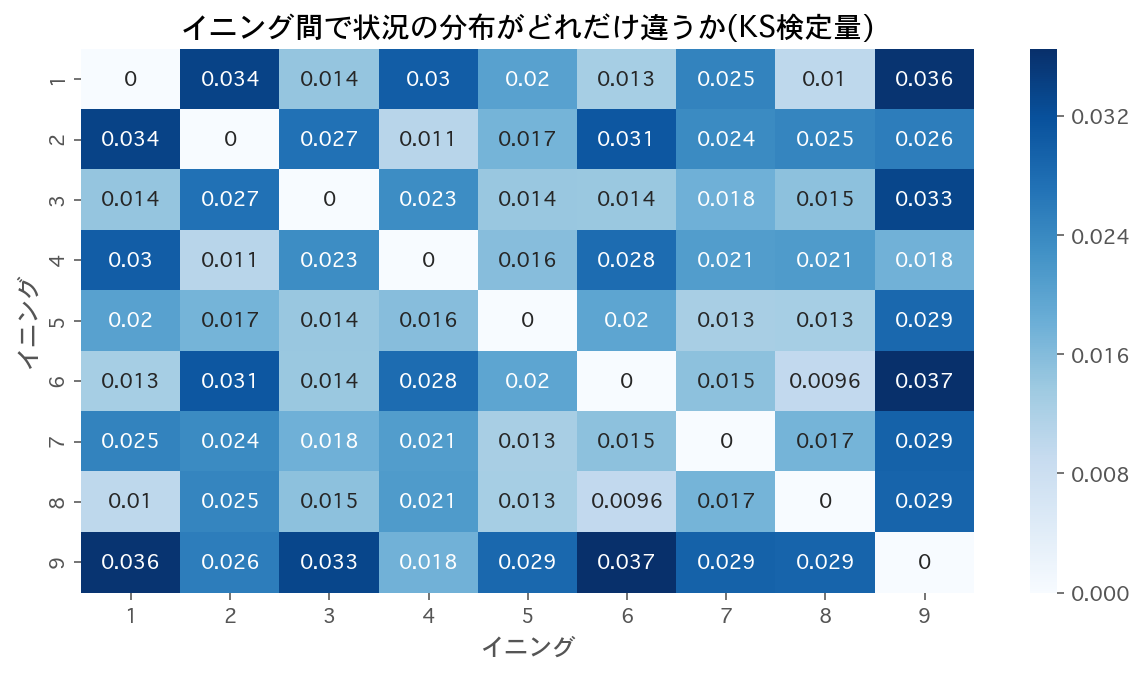

In [16]:
plt.figure(figsize=(10, 5))
sns.heatmap(df, cmap="Blues", annot=True)
plt.xlabel("イニング")
plt.ylabel("イニング")
plt.title("イニング間で状況の分布がどれだけ違うか(KS検定量)")